In [154]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [155]:
# Import df
def import_df(date):
    votes_df = pd.read_csv(f"datasets/votacoesVotos-{date}.csv", delimiter=";")
    orientation_df = pd.read_csv(f"datasets/votacoesOrientacoes-{date}.csv", delimiter=";")
    votes_df = votes_df[['idVotacao', 'voto',
                         'deputado_id', 'deputado_nome',
                         'deputado_siglaPartido']]
    orientation_df = orientation_df[['idVotacao',
                                     'siglaBancada',
                                     'orientacao']]
    votes_df = votes_df.rename(columns={"deputado_siglaPartido": "siglaBancada"})
    free_orientation_df = orientation_df.query('orientacao=="Sim" | orientacao=="Não"')
    #free_orientation_df = orientation_df.query('orientacao=="Liberado"')
    return votes_df, free_orientation_df

In [156]:
def merge_dfs(votes_df, free_orientation_df):
    return pd.merge(free_orientation_df,
             votes_df,
             on=["idVotacao", "siglaBancada"],
             how="inner")

In [157]:
def group_by_df(vo_df):
    return vo_df.groupby(by=["deputado_id", "deputado_nome"]).agg({'idVotacao': lambda x: ','.join(x),
                                                                            'voto': lambda x: ','.join(x),
                                                                            #'deputado_id': 'max',
                                                                            #'deputado_nome': 'max'
                                                                            }).reset_index()

In [158]:
def get_dep_votes(grouped_vo_df):
    dep_votes = dict()
    for index, row in grouped_vo_df.iterrows():
        votes = dict(zip(row["idVotacao"].split(","), row["voto"].split(",")))
        dep_votes[row["deputado_id"]] = votes
    return dep_votes

def combine_deps(dep_votes):
    return list(itertools.combinations(dep_votes.keys(), 2))


In [159]:
def calculate_corr(dep_combinations, dep_votes):
    corr_dict = dict()
    for deps in dep_combinations:
        shared_items = dict()
        same_propositions = list()
        for k in dep_votes[deps[0]]:
            if k in dep_votes[deps[1]]:
                same_propositions.append(k)
                if dep_votes[deps[0]][k] == dep_votes[deps[1]][k]:
                    shared_items[k] = dep_votes[deps[0]][k]
        if len(same_propositions) == 0:
            corr_dict[deps] = 0
        else:
            corr_dict[deps]= len(shared_items)/len(same_propositions)
    return corr_dict

def sort_corr(corr_dict):
    return sorted(corr_dict.items(), key=lambda x: x[1], reverse=True)


In [160]:
def process():
    all_dates_dict = dict()
    for vote_date in ['2021','2019','2020']:
        votes_df, free_orientation_df = import_df(vote_date)
        vo_df = merge_dfs(votes_df, free_orientation_df)
        grouped_vo_df = group_by_df(vo_df)
        dep_votes = get_dep_votes(grouped_vo_df)
        dep_combinations = combine_deps(dep_votes)
        corr_dict = calculate_corr(dep_combinations, dep_votes)
        all_dates_dict = {**all_dates_dict, **corr_dict}
    return all_dates_dict

all_dates_dict = process()
all_dates_dict_sorted = sort_corr(all_dates_dict)

In [161]:
G=nx.Graph()
for edge in all_dates_dict_sorted:
    if edge[1] > 0:
        G.add_edge(edge[0][0], edge[0][1], weight=edge[1])

In [162]:
n_V = G.number_of_nodes()
n_E = G.number_of_edges()
print(f"Number of nodes: {n_V}")
print(f"Number of edges: {n_E}")
print(f"Directed graph: {nx.is_directed(G)}")
print(f"Connected graph: {nx.is_connected(G)}")
print(f"Connected components: {nx.number_connected_components(G)}")

Number of nodes: 574
Number of edges: 158660
Directed graph: False
Connected graph: True
Connected components: 1


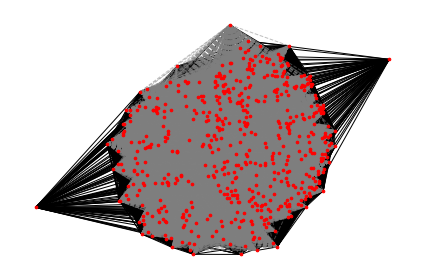

In [163]:
# Draw graph
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0.5]

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=7, node_color="red")
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="grey", style="dashed"
)

# labels
#nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_color="white")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


In [164]:
nx.write_edgelist(G, f"networks/vote19-20-21-orientado.txt", delimiter=' ', data=['weight'])